# Домашнее задание №2 "Элементарные методы анализа временных рядов"

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. 
Оценить качество и прислать соображения почему была выбрана та или иная модель

Ряды из прошлого дз:

- “monthly-sales-of-company-x-jan-6.csv”, 
- “monthly-boston-armed-robberies-j.csv”, 
- “international-airline-passengers.csv”, 
- “mean-monthly-air-temperature-deg.csv”, 
- “weekly-closings-of-the-dowjones-.csv”, 
- "daily-total-female-births-in-cal.csv"

## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

## Используемые функции

In [2]:
def initial_trend(series, season_len):
    '''Функция, которая учитывает уровень значения с учётом тренда и сезонности.
    Вход - данные и длина сезона. 
    Выход - значение прогноза, одна из составляющих'''
    i = 0
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    '''Функция, которая учитывает сезонные компоненты.
    Вход - данные и длина сезона. 
    Выход - сезонные компоненты в зависимости от длины сезона'''
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        sv = sum(series[slen * j : slen * j + slen]) / float(slen)
        season_averages.append(sv)
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24, sesLen=12):
    tema = triple_exponential_smoothing(ser, sesLen, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
        
def mse_cross_val(X):
    '''Функция выводит ошибку между тестом и прогнозом на тройном экспоненциальном сглаживании. 
    При этом в процессе проводит кросс-валидацию данных'''
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_1):
        train_split_ts = train_1.iloc[train_split]
        test_split_ts = train_1.iloc[test_split]
        #print(train_split_ts)
        #print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))


def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return pd.Series(result)

def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()
        
        
def mse_cross_val_stationarity(X):
    '''Функция выводит ошибку между тестом и прогнозом на двойном экспоненциальном сглаживании. 
    При этом в процессе проводит кросс-валидацию данных'''
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_2):
        train_split_ts = train_2.iloc[train_split]
        test_split_ts = train_2.iloc[test_split]
        #print(train_split_ts)
        #print(test_split_ts)
        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

## Выберем один стационарный и один нестационарный ряд

In [4]:
# нестационарный
sales_of_company_x = pd.read_csv("Series\monthly-sales-of-company-x-jan-6.csv")
# стационарный
female_births = pd.read_csv("Series\daily-total-female-births-in-cal.csv")

In [5]:
female_births.head()

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [6]:
sales_of_company_x.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [7]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Daily total female births in California": female_births["Count"]
}

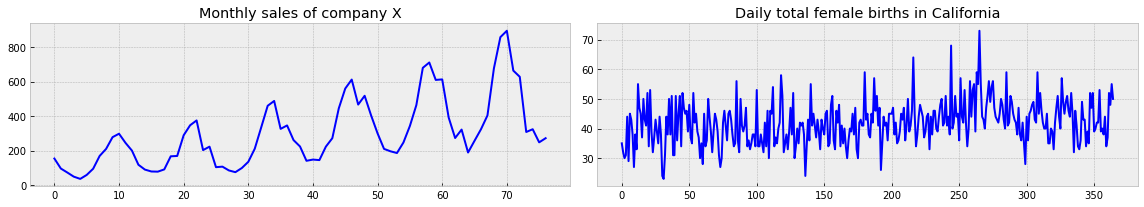

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()


  1. "Monthly sales of company X": ряд нестационарный - есть сезонность + тренд
  1. "Daily total female births in California": ряд стационарный

## 1. Нестационарный ряд. "Monthly sales of company X"

In [12]:
series_1 = sales_of_company_x["Count"]
len(series_1)

77

In [13]:
# разделение данных на 75% - train, 25% - val
train_1, val_1 = series_1[:58], series_1[58:]

Так в данном ряде есть уровень, тренд и сезонность, то наиболее удачно должна показать себя модель тройного экспоненцинциального сглаживания по методу Хольт-Винтерса.


$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

Попробуем построить приблизить к модели TEMA с произвольными параметрами alpha=beta=gamma=0.1 и построить сам временной ряд и его модель на количество точек предсказания 24.

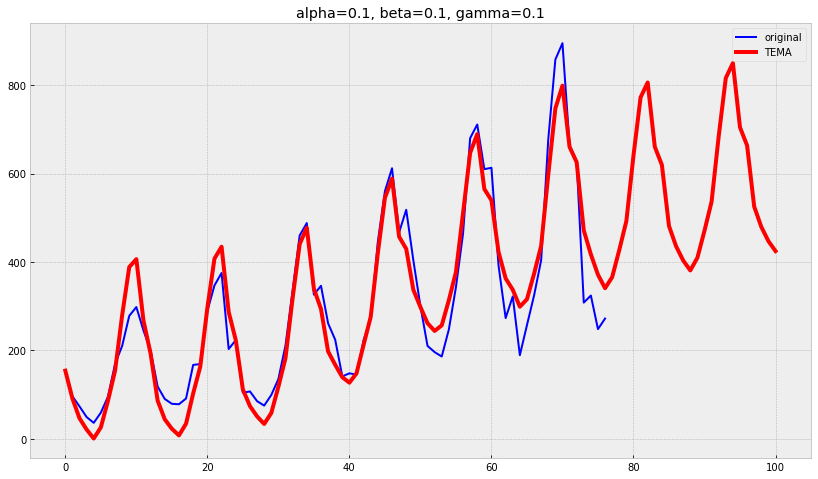

In [14]:
plot_tema(alpha=0.1, beta=0.1, gamma=0.1, ser=series_1, ser_to_plot=series_1, n_preds=24, sesLen=12)

Получилось довольно хорошо. Но попробуем оптимизировать параметры при помощи MSE и модуля optimize.

##### "Nelder-Mead"

In [15]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


21422.988669348804------------
21351.7074256164------------
21422.988669348804------------
21417.333321924758------------
21371.85145251673------------
21337.782153682896------------
21295.57893292799------------
21262.952623917892------------
21187.211891287057------------
21184.412699027456------------
21091.895888329662------------
21034.74020280973------------
20882.146786380556------------
20817.45163784359------------
20590.19982258001------------
20529.37838946481------------
20220.69660862876------------
20070.74140977757------------
19621.308102255793------------
19454.74238604505------------
18849.25950628069------------
18644.215024024204------------
17890.75014324152------------
17619.50748516723------------
16783.725366096627------------
16457.19667124999------------
15619.092720533852------------
15466.205594298408------------
15065.789019667014------------
15066.777096953521------------
15248.052057746221------------
16274.645823128449------------
15062.162992121303-----

2947.299778736529------------
2953.783140480619------------
2947.0608419472774------------
2944.690923922286------------
2944.06233740556------------
2947.255506391102------------
2945.867384687952------------
2943.908939747265------------
2943.943820651871------------
2942.9349264055963------------
2942.735760699013------------
2941.5050630017736------------
2940.660000975011------------
2941.2949000298436------------
2943.454697638296------------
2940.9364268887766------------
2940.7439159751625------------
2939.311174718181------------
2939.065449680727------------
2944.788800983584------------
2939.674072118079------------
2939.6141850120534------------
2937.5636244004577------------
2936.6399017261624------------
2937.495411608556------------
2936.222578961897------------
2940.839074224114------------
2934.9204181666114------------
2939.0382755522937------------
2943.8535265584437------------
2935.7926271383735------------
2934.0758359386186------------
2933.301639051066----------

2909.6108721739633------------
2909.5361461872867------------
2909.499397526304------------
2909.585276496478------------
2909.6697636679714------------
2909.5593209996164------------
2909.528516991227------------


In [16]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[3.90538874e-04, 3.62002260e+01, 8.41025795e-01],
       [3.90569617e-04, 3.60063242e+01, 8.44863853e-01],
       [3.96745235e-04, 3.55848838e+01, 8.40520341e-01],
       [3.84644002e-04, 3.65675661e+01, 8.39121110e-01]]), array([2909.49939753, 2909.52851699, 2909.559321  , 2909.5852765 ]))
           fun: 2909.499397526304
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 600
           nit: 351
        status: 1
       success: False
             x: array([3.90538874e-04, 3.62002260e+01, 8.41025795e-01])


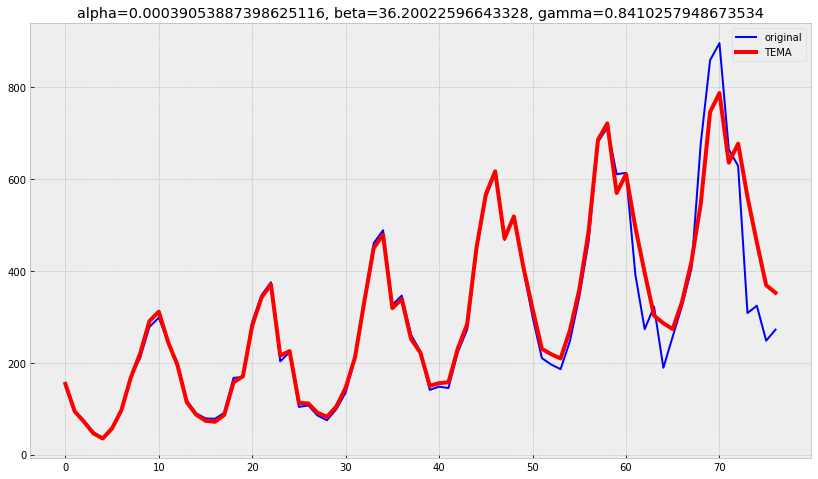

In [17]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train_1, ser_to_plot=series_1, n_preds=len(val_1))

##### "L-BFGS-B"

In [19]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

21422.988669348804------------
21422.985808839647------------
21422.988669348866------------
21422.98844310125------------
8464.887331900352------------
8464.887311844397------------
8464.886689268127------------
8464.887331900352------------
8327.361306067512------------
8327.361285152685------------
8327.36134076223------------
8327.361306067512------------
8270.536343796006------------
8270.536364269603------------
8270.536390037652------------
8270.536343907064------------
7918.56793537247------------
7918.567956140351------------
7918.568022403039------------
7918.567935995067------------
8270.887646381872------------
8270.887665197271------------
8270.88700145071------------
8270.887648579219------------
7067.774694011743------------
7067.774716337682------------
7067.774750379561------------
7067.774695492871------------
6995.960228415672------------
6995.960249852974------------
6995.960184623902------------
6995.960230125882------------
7468.328126967836------------
7468.32814

In [20]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 6266.8421740173535
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.81898939e-04,  1.81898940e-04, -3.46467730e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 13
     njev: 22
   status: 0
  success: True
        x: array([0.55184973, 0.06900286, 1.        ])


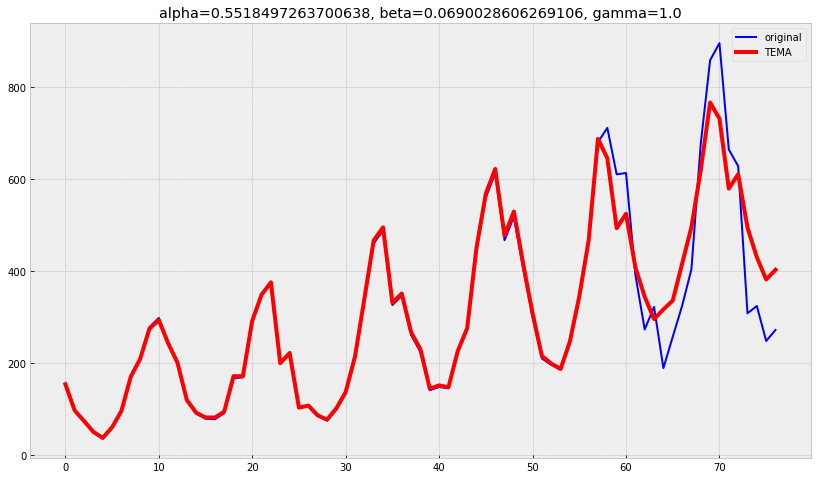

In [21]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train_1, ser_to_plot=series_1, n_preds=len(val_1))

##### "SLSQP"

In [22]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="SLSQP", bounds = ((0, 1), (0, 1), (0, 1)))

21422.988669348804------------
21422.984406858075------------
21422.988669348804------------
21422.988332213674------------
8464.887331900352------------
8087.885737086006------------
8184.414461392207------------
8184.414472919244------------
8184.413287883235------------
8184.41444190359------------
28069.528198053285------------
8673.821429525264------------
8527.971999140516------------
6226.212876907997------------
6226.212971310182------------
6226.212997187801------------
6226.21287806398------------
7614.666398213621------------
5568.521506048622------------
5568.521673081952------------
5568.521553025016------------
5568.521515132764------------
21422.988669348786------------
5301.825073541656------------
5301.825238791124------------
5301.825070818428------------
5301.825076955157------------
14336.474499393727------------
5082.999444723949------------
5082.999604287773------------
5082.999406314118------------
5082.999443888321------------
10581.658198434789------------
4844

In [23]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

     fun: 3007.4723135197823
     jac: array([ 9.61608887e-02, -1.00601074e+02,  2.56347656e-03])
 message: 'Optimization terminated successfully'
    nfev: 122
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([0.01284611, 1.        , 0.8835846 ])


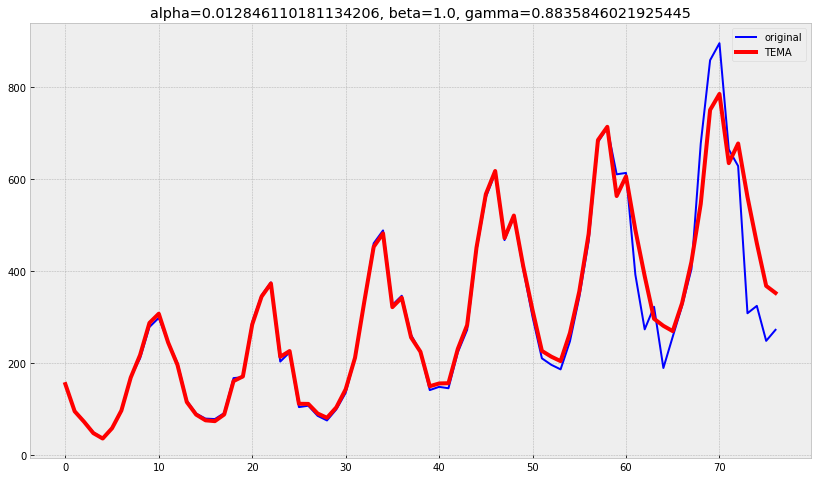

In [24]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train_1, ser_to_plot=series_1, n_preds=len(val_1))

Были испытаны все методы оптимизации для метода optimize - здесь оставлены лучшие три ("Nelder-Mead", "SLSQP", "L-BFGS-B"). Лучше всего показал себя "Nelder-Mead" с наименьшим уровнем ошибки по RMSE

## 2. Стационарный ряд. "Daily total female births in California"

In [25]:
series_2 = female_births["Count"]
len(series_2)

365

In [26]:
# разделение данных на 75% - train, 25% - val
train_2, val_2 = series_2[:274], series_2[274:]

Так в данном ряде есть уровень, тренд, то здесь наиболее удачно должна показать себя модель двойного экспоненцинциального сглаживания

$$\hat{y}_t=l_t + s_t$$

$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$

$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$


Ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

Попробуем построить приблизить к модели DEMA с произвольными параметрами alpha=beta=0.1 и построить сам временной ряд.

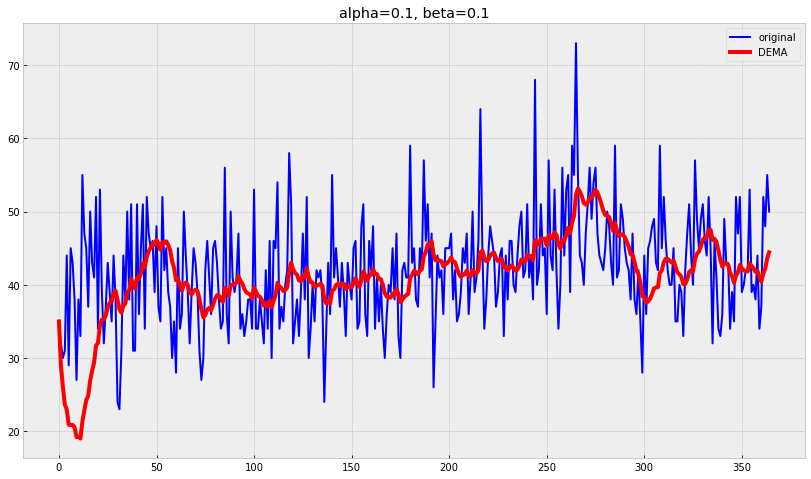

In [27]:
plot_dema(series_2, 0.1, 0.1)

Получилось хорошо. Но попробуем оптимизировать параметры. Сделаем это при помощи MSE и модуля optimize.

##### "Nelder-Mead"

In [28]:
opt_2 = minimize(mse_cross_val_stationarity, x0=[0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1)))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


134915.2156862745------------
129849.06634898436------------
134915.2156862745------------
129918.49797997164------------
125151.43791687085------------
120697.85424837557------------
120506.15055096988------------
116074.87990695749------------
108403.2243001953------------
99701.24941234432------------
95782.66598375754------------
85753.27099252206------------
75535.99340211------------
63164.74220727971------------
55180.326792157495------------
43086.454798359766------------
35958.88343590615------------
27666.028839667735------------
21570.786659081863------------
16065.33061423237------------
15640.314527390912------------
15517.390000475732------------
13645.413849137249------------
16978.374310182797------------
23787.60914119588------------
13671.510355281227------------
11187.324416332818------------
9485.701216167881------------
10673.160557272951------------
7026.04037095426------------
5045.003073347297------------
5065.051379772854------------
2585.3497843498135---------

In [29]:
alpha_opt_2, beta_opt_2 = opt_2.x
print(opt_2)

 final_simplex: (array([[0.22277501, 0.09822703],
       [0.22275752, 0.0982878 ],
       [0.22282632, 0.09827213]]), array([66.59663657, 66.59663722, 66.59663834]))
           fun: 66.59663657406259
       message: 'Optimization terminated successfully.'
          nfev: 101
           nit: 54
        status: 0
       success: True
             x: array([0.22277501, 0.09822703])


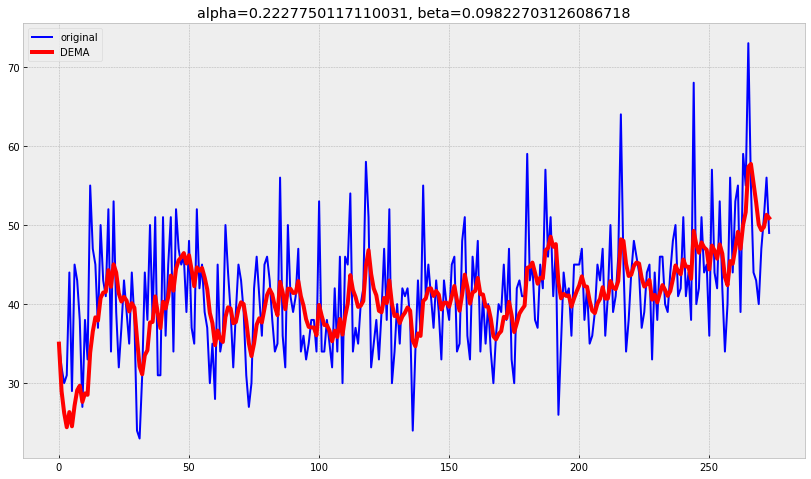

In [30]:
plot_dema(train_2, alpha_opt_2, beta_opt_2)

##### "L-BFGS-B"

In [31]:
opt_2 = minimize(mse_cross_val_stationarity, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

134915.2156862745------------
134915.0081589943------------
134915.2156862716------------
131.1150767922223------------
131.11507539431625------------
131.1150780622825------------
131.11298061472155------------
131.11298201258208------------
131.11298188475322------------
131.10459648739462------------
131.10459788507282------------
131.1045977573122------------
131.07106929756733------------
131.07107069451675------------
131.07107056702878------------
130.9371094366505------------
130.9371108306909------------
130.93711070429063------------
130.40363880227684------------
130.40364018478158------------
130.40364006268496------------
128.30681064875316------------
128.30681198667176------------
128.30681188105368------------
120.46335322925489------------
120.46335441082772------------
120.463354360423------------
119.33241557047461------------
119.33241564165674------------
119.33235641595468------------
118.61105697555882------------
118.6110581222196------------
118.61105808214297-

In [32]:
alpha_opt_2, beta_opt_2 = opt_2.x
print(opt_2)

      fun: 66.59663647470735
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.95807864e-05, -7.10542736e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 14
     njev: 27
   status: 0
  success: True
        x: array([0.2227775 , 0.09824074])


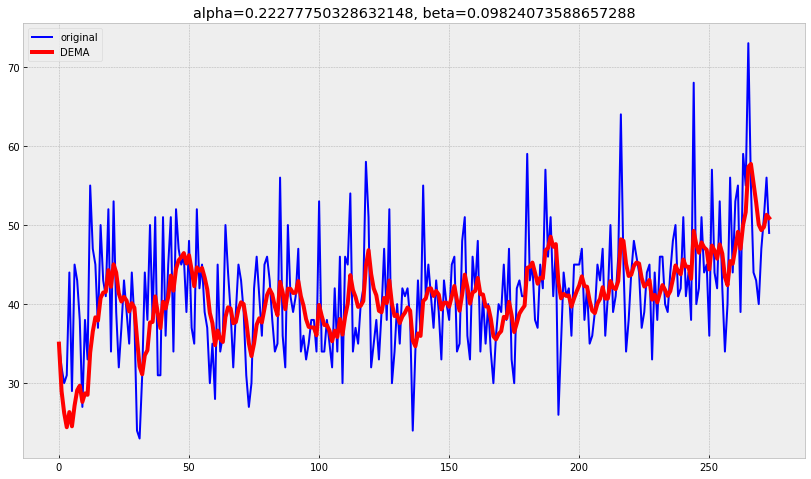

In [33]:
plot_dema(train_2, alpha_opt_2, beta_opt_2)

##### "SLSQP"

In [34]:
opt_2 = minimize(mse_cross_val_stationarity, x0=[0,0], method="SLSQP", bounds = ((0, 1), (0, 1)))

134915.2156862745------------
134914.90644667545------------
134915.2156862745------------
129.2549019607843------------
130.62029472634936------------
242.03458387437493------------
653.3062846827543------------
1973.8378957395737------------
5579.323077418034------------
5579.319334373206------------
5579.310847459458------------


In [35]:
alpha_opt_2, beta_opt_2 = opt_2.x
print(opt_2)

     fun: 5579.323077418034
     jac: array([-251191.48626709, -820738.62677002])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 6
    njev: 2
  status: 0
 success: True
       x: array([0.0379313, 0.       ])


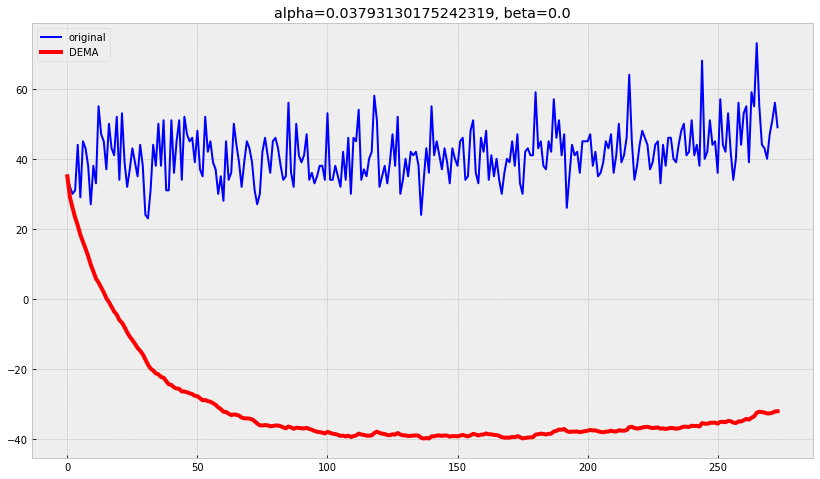

In [36]:
plot_dema(train_2, alpha_opt_2, beta_opt_2)

Были испытаны все методы оптимизации для метода optimize - здесь оставлены наиболее показательные три ("Nelder-Mead", "SLSQP", "L-BFGS-B"). Лучше всего показал себя "Nelder-Mead" с наименьшим уровнем ошибки по RMSE - однако в данном случае многие методы показывали примерно такие же результаты, за исключением  "SLSQP".